In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from bosonicplus.conversions import r_to_dB, dB_to_r, Delta_to_dB, to_dB
from bosonicplus.base import State
from bosonicplus.operations.symplectic import squeezing, beam_splitter, expand_symplectic_matrix

from thewalrus.symplectic import xxpp_to_xpxp, xpxp_to_xxpp
from thewalrus.decompositions import blochmessiah

from bosonicplus.plotting import plot_wigner_marginals
from bosonicplus.effective_sqz import effective_sqz
from bosonicplus.gkp_squeezing import Q_expval

import matplotlib as mpl
from matplotlib import pyplot as plt

hbar = 2
colwidth = 3.41667

fs = 10

mpl.rcParams.update({'font.size': fs, 
                     "text.usetex":  True, 
                     'font.family':'serif',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize':8 })


kwargs = {'grid': 'rect', 
          'fontsize' : fs, 
          'title': None, 
          'figsize' :(colwidth,colwidth), 
          'linewidth':1,
          'xlim': 5,
          'plim': 5}

fig_kwargs = {'dpi':800, 'bbox_inches': 'tight'}



## Generalised photon subtraction parameters from Takase et al. https://doi.org/10.1038/s41534-023-00772-y

hbar =2
r1 = dB_to_r(-9.5)


r2 = dB_to_r(6.9)
r3 = dB_to_r(5.2)

D1 = np.exp(-r1)
D2 = np.exp(-r2)
D3 = np.exp(-r3)
g = 0.59

## Coherent bifurcation conditions
print('1st condition, (D2^(-2)+g^2 D1^(-2)) * D3^(-2) = 1', D3**(-2)*(D2**(-2)+g**2*D1**(-2)))
print('2nd condition, D1^2 << D2^2', f'{D1**2} << {D2**2}')

print('factor', D2**2/D1**2)


1st condition, (D2^(-2)+g^2 D1^(-2)) * D3^(-2) = 1 0.9985827654331072
2nd condition, D1^2 << D2^2 0.11220184543019635 << 4.897788193684462
factor 43.65158322401659


In [2]:
#For a given g, find bloch-messiah decomp of circuit implementing QND operation

g = 0.59
QND = np.array([[1,0,g,0],[0,1,0,0],[0,0,1,0],[0,-g,0,1]])
r = np.arcsinh(g/2)
theta = np.arcsin(-1/np.cosh(r))/2

S1 = expand_symplectic_matrix(squeezing(r, 0),[0], 2)
S2 = expand_symplectic_matrix(squeezing(r, np.pi),[1], 2)

B1 = beam_splitter(theta, np.pi)
B2 = beam_splitter(theta+np.pi/2, np.pi)

Stot = B2 @ S1 @ S2 @ B1

print(np.allclose(QND,Stot))

True


In [3]:
def coh_bifur_params(n, g = 1, c = 1, w = np.sqrt(np.pi), factor = 50, out = False):
    """Generate coherent bifurcation circuit parameters
    Args:
        n (int): photon number
        g (float): QND interaction strength
        w (float): grid spacing
        factor (float): D2^2 = factor*D1^2
        out (bool): 
    Returns:
        r1 (float): squeezing of input state
        g (float): QND interaction strength
        r2 (float): squeeizng of ancillary states
        r3 (float): inline squeezing prior to pnrd
    """
    #Task: find r1 from w = sqrt(pi) = D1 sqrt(2 n)
    D1 = w/np.sqrt(2*n)
    r1 = -np.log(D1)

    #Task: find r2, r3 such that D1^2 << D2^2 and D3^(-2)*(D2^(-2)+g^2 * D1^(-2)) == c
    
    #Choose D2^2 = factor  D1^2
    #D2 = np.sqrt(D1**2 * factor)
    
    D2 = np.exp(1) #For comparison with Table 1 in Takase et al. https://doi.org/10.1038/s41534-023-00772-y
    r2 = -np.log(D2)
    
    D3 = np.sqrt((D2**(-2)+g**2 * D1**(-2))/c)
    r3 = -np.log(D3)
    if out:
        print(f'r1 {r_to_dB(r1)} [dB]')
        print(f'r2 {r_to_dB(r2)} [dB]')
        print(f'r3 {r_to_dB(r3)} [dB]')
    return r1, g, r2, r3


In [4]:
def coherent_bifurcation_step(state, n, params, eta = 1, infid = 1e-6):
    """Perform a coherent bifurcation step. Updates the state object.
    Args:
        state (bosonicplus.base.State): input state
        n (int): photon number measurement
        params (np.ndarray): list of parameters
        eta (float): transmissivity of loss channel
        infid (float): infidelity of fock approximation for the measurement
    Returns: 
        prob (float): probability of photon measurement     
    """
    
    r1, g, r2, r3 = params
    
    sq_state = State(1) #Generate ancillary state
    sq_state.apply_symplectic(squeezing(r2,0))
    state.add_state(sq_state) #Tensor product the two states
   
    QND = np.array([[1,0,g,0],[0,1,0,0],[0,0,1,0],[0,-g,0,1]])
    
    state.apply_symplectic(QND) #Apply QND
    state.apply_symplectic_fast(squeezing(r3,0),[1]) #Apply squeezing on last mode

    state.apply_loss(np.repeat(eta, 2), np.zeros(2)) #Apply a pure loss channel on both modes
    
    state.post_select_fock_coherent(1, n, inf=infid, out = True)
    prob = state.norm 
    state.normalise() #Divide by norm
    return prob
    

In [5]:
from bosonicplus.effective_sqz import effective_sqz
from bosonicplus.gkp_squeezing import Q_expval
from bosonicplus.conversions import Delta_to_dB, to_dB

def print_state_info(state, grid = 'r'):
    Dx = effective_sqz(state,grid+'x')
    Dp = effective_sqz(state,grid+'p')
    Ds = np.sqrt(0.5*(Dx**2+Dp**2))
    
    print('Dx', Delta_to_dB(Dx).real, '[dB]')
    print('Dp', Delta_to_dB(Dp).real, '[dB]')
    print('Ds', Delta_to_dB(Ds).real, '[dB]')
    print('Q0', Q_expval(state,'0'))
    print('Q1', Q_expval(state,'1'))

Bifurcation step 0
r1 -10.080001056257721 [dB]
r2 8.685889638065037 [dB]
r3 10.137323666584336 [dB]
Dx 10.080001056257721 [dB]
Dp -10.080001056257723 [dB]
Ds -7.11135920648449 [dB]
Q0 (1.0742085487963688+0j)
Q1 (2.925791451203605+0j)
--------------------------------------------------
Bifurcation step 1.
Measuring 16 photons in mode 1.
Data shape before measurement, [(1, 4), (1, 4, 4)].
Probability of measurement = 1.480e-02
Data shape after measurement, [(153, 2), (1, 2, 2)]
Dx 10.170221979177605 [dB]
Dp 6.554359928233704 [dB]
Ds 7.9963696128772055 [dB]
Q0 (2.4279639561421833-2.710505431213761e-20j)
Q1 (0.5734544317207648+2.710505431213761e-20j)
Probability 0.01479995706932471


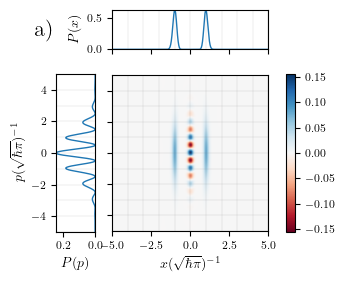

--------------------------------------------------
Bifurcation step 2.
Measuring 16 photons in mode 1.
Data shape before measurement, [(153, 4), (1, 4, 4)].
Probability of measurement = 2.221e-02
Data shape after measurement, [(41905, 2), (1, 2, 2)]
num weights after reduction 561
Dx 10.285039456170427 [dB]
Dp 8.87558269311969 [dB]
Ds 9.523382222963052 [dB]
Q0 (0.40528463548862825-8.257347252791855e-12j)
Q1 (2.2634234834042384-2.2078655228944047e-11j)
Probability 0.00032870076545401595


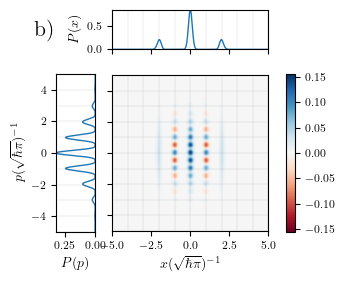

--------------------------------------------------
Bifurcation step 3.
Measuring 16 photons in mode 1.
Data shape before measurement, [(561, 4), (1, 4, 4)].
Probability of measurement = 2.469e-02
Data shape after measurement, [(157641, 2), (1, 2, 2)]
num weights after reduction 1225
Dx 10.39518129178187 [dB]
Dp 10.357305140699635 [dB]
Ds 10.376201925183244 [dB]
Q0 (2.1820197489991515-8.260257821713149e-10j)
Q1 (0.32047595557123515-1.0331240998329508e-09j)
Probability 8.115202467052729e-06


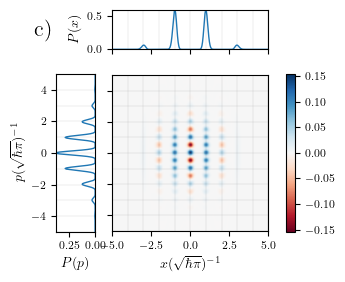

--------------------------------------------------
Bifurcation step 4.
Measuring 16 photons in mode 1.
Data shape before measurement, [(1225, 4), (1, 4, 4)].
Probability of measurement = 2.594e-02
Data shape after measurement, [(347361, 2), (1, 2, 2)]
num weights after reduction 2145
Dx 10.505221355147098 [dB]
Dp 11.45053405205086 [dB]
Ds 10.952207979810574 [dB]
Q0 (0.2690076503329819-5.041669179904097e-08j)
Q1 (2.1338804091230563-1.0415689613758623e-07j)
Probability 2.1047554961053064e-07


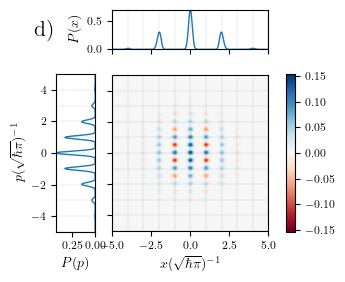

total prob 2.1047554961053064e-07


In [8]:
#Setting up the simulation
g = 1 #QND interaction strength
c = 1
w = np.sqrt(np.pi)
nt = 16 #Target photon number
N = 4 #Number of bifurcation steps
eta = 1 #Loss channel transmissivity

print(f'Bifurcation step 0')
#Generate the bifurcation parameters
params = coh_bifur_params(nt, g, c, w, out = True) 
r1 = params[0]

#Generate input squeezed state
state = State(1)
state.apply_symplectic(squeezing(r1,0))
print_state_info(state)

x = np.linspace(-15,15,300) #For plotting the Wigner function
labels = ['a)', 'b)', 'c)', 'd)']

pattern = np.repeat(nt,N) 
probs = np.zeros(N)
for i, n in enumerate(pattern):
    print('-'*50)
    print(f'Bifurcation step {i+1}.')
    probs[i] = coherent_bifurcation_step(state, n, params, eta = eta) #Perform the bifurcation
    if i != 0:
        if eta == 1:
            state.reduce_pure(np.sum(pattern[0:i+1]), infid = 1e-8) #Reduce the number of Gaussians
        else:
            state.reduce_mixed(sd = 14) #Reduce the number of Gaussians
        print('num weights after reduction', state.num_weights)
        
    print_state_info(state)
    print('Probability', np.prod(probs[0:i+1]))

    W = state.get_wigner_log(x,x)
    fig, ax, axx, axp, axv = plot_wigner_marginals(W.real, x,x, **kwargs)
    axx.text(-0.5, 1.25, labels[i], fontsize = 16, transform=ax.transAxes)
    plt.savefig(f'figures/W_coherent_bifur_step_{i}.pdf', **fig_kwargs)
    plt.show()

print('total prob', np.prod(probs))

num weights 357
Dx 8.051149842569112 [dB]
Dp 7.825375384360125 [dB]
Q0 (0.5202441638365525+2.007867205941751e-16j)
Q1 (2.288735895259914+9.218597496576171e-17j)
(0.9023754203226412+4.039234648391864e-12j)


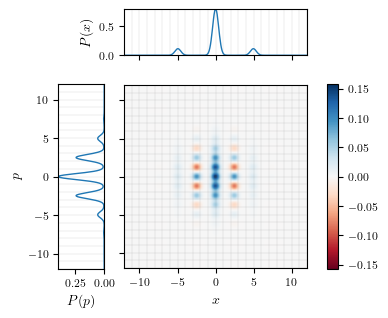

In [7]:
from bosonicplus.states.from_sf import prepare_gkp_bosonic
from bosonicplus.fidelity import overlap_log

## Compare with Gaussian GKP
D1 = np.exp(-r1)

gkp = prepare_gkp_bosonic([0,0], D1**2)
print('num weights', gkp.num_weights)
print('Dx', Delta_to_dB(effective_sqz(gkp,'rx').real), '[dB]')
print('Dp', Delta_to_dB(effective_sqz(gkp,'rp').real), '[dB]')
print('Q0', Q_expval(gkp,'0'))
print('Q1', Q_expval(gkp,'1'))

print(overlap_log(gkp, state))
x = np.linspace(-12,12,300)
W = gkp.get_wigner_log(x,x)
plot_wigner_marginals(W.real, x,x)
plt.show()
